In [1]:
import os
import random
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import mmcv
from mmcv import Config
from mmdet.datasets.utils import get_dataset
import cv2

image_dir = 'data/dataset/images'
filenames = os.listdir(image_dir)

cfg = Config.fromfile('configs/baseline.py')
ds = get_dataset(cfg.data.train)

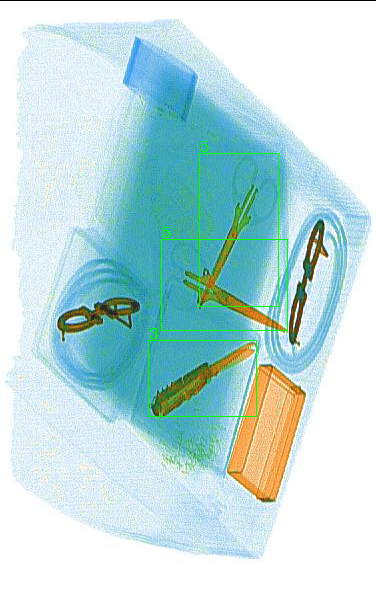

In [2]:
def _rotate_img(img, angle):
    """Rotate img
    Args:
        img(numpy.ndarray): (h, w, c)
        angel(int or float): one of (90, 180, 270)
    """
    (img_h, img_w) = img.shape[:2]
    (center_x, center_y) = (img_w // 2, img_h // 2)

    M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)

    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((img_h * sin) + (img_w * cos))
    nH = int((img_h * cos) + (img_w * sin))

    M[0, 2] += (nW / 2) - center_x
    M[1, 2] += (nH / 2) - center_y

    rotated_img = cv2.warpAffine(img, M, (nW, nH))

    return rotated_img


def _rotate_bboxes(bboxes, img_shape, angle):
    img_h, img_w = img_shape[:2]
    center_x, center_y  = ((img_w - 1) * 0.5, (img_h - 1) * 0.5)

    M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)

    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((img_h * sin) + (img_w * cos))
    nH = int((img_h * cos) + (img_w * sin))

    M[0, 2] += (nW / 2) - center_x
    M[1, 2] += (nH / 2) - center_y

    bb_w = (bboxes[:, 2] - bboxes[:, 0]).reshape(-1, 1)
    bb_h = (bboxes[:, 3] - bboxes[:, 1]).reshape(-1, 1)

    x1 = bboxes[:, 0].reshape(-1, 1)
    y1 = bboxes[:, 1].reshape(-1, 1)

    x2 = x1 + bb_w
    y2 = y1

    x3 = x1
    y3 = y1 + bb_h

    x4 = bboxes[:, 2].reshape(-1, 1)
    y4 = bboxes[:, 3].reshape(-1, 1)

    corners = np.hstack((x1, y1, x2, y2, x3, y3, x4, y4))
    corners = corners.reshape(-1, 2)
    corners = np.hstack((corners, np.ones((corners.shape[0], 1))))

    calculated = np.dot(M, corners.T).T

    calculated = calculated.reshape(-1, 8)

    x_ = calculated[:, [0, 2, 4, 6]]
    y_ = calculated[:, [1, 3, 5, 7]]

    xmin = np.min(x_, 1).reshape(-1, 1)
    ymin = np.min(y_, 1).reshape(-1, 1)
    xmax = np.max(x_, 1).reshape(-1, 1)
    ymax = np.max(y_, 1).reshape(-1, 1)

    rotate_bboxes = np.hstack((xmin, ymin, xmax, ymax, calculated[:, 8:]))
    return rotate_bboxes.astype(dtype=np.float32)


def _rotate_ann(ann, img_shape, angle):
    rotated_ann = ann.copy()
    rotated_ann['bboxes'] = _rotate_bboxes(rotated_ann['bboxes'], img_shape, angle)
    rotated_ann['bboxes_ignore'] = _rotate_bboxes(rotated_ann['bboxes_ignore'], img_shape, angle)
    return rotated_ann


def _rotate_img_info(img_info, angle):
    orig_h, orig_w = img_info['height'], img_info['width']
    if angle in [90, 270]:
        h, w = orig_w, orig_h
    else:
        h, w = orig_h, orig_w
    rotated_img_info = img_info.copy()
    rotated_img_info['height'] = h
    rotated_img_info['width'] = w
    return rotated_img_info


def rotate(img, ann, img_info, prob=0.5):
    """Rotate image and bboxes
    Args:
        img(numpy.ndarray): (h, w, c)
        ann(dict): bboxes shape(m, 4), (x1, y1, x2, y2); labels shape(m,); bboxes_ignore shape(n, 4)
        img_info(dict): id, filename, height, width
        prob(float): rotate probability, 0<=prob<=1
    """
    if random.random()>=prob:
        return img, ann, img_info
    
    angle = random.choice([90, 180, 270])
    rotated_img = _rotate_img(img, angle)
    rotated_ann = _rotate_ann(ann, img.shape, angle)
    rotated_img_info = _rotate_img_info(img_info, angle)
    return rotated_img, rotated_ann, rotated_img_info

img, ann, img_info = ds._get_img_ann(random.randint(0, len(ds)))
rotated_img, rotated_ann, rotated_img_info = rotate(img, ann, img_info, prob=1.0)
mmcv.imshow_det_bboxes(Image.fromarray(rotated_img), rotated_ann['bboxes'], rotated_ann['labels'])